In [2]:
import pandas as pd
import numpy as np
import nfl_data_py as nfl
import seaborn as sns
import matplotlib.pyplot as plt
import mitosheet

#### Loading Data
To study the stability of passing data, we loaded NFL data from 2016 to 2022 as play-by-play.
Using 2016 is largely an arbitrary choice. In this case, it’s the last year with a material rule change (moving the kickoff touchback up to the 25-yard line) that affected game play. Other seasons are natural breaking points, like 2002 (the last time the league expanded), 2011 (the last influential change to the league’s collective bargaining agreement), 2015 (when the league moved the extra point back to the 15-yard line),
2020 (the COVID-19 pandemic, and also when the league expanded the playoffs),
and 2021 (when the league moved from 16 to 17 regular-season games).
We used the following code to load the data:

```python
seasons = range(2016, 2022 + 1) 
pbp_py = nfl.import_pbp_data(seasons)
```

Next, to get the subset of data we needed for this analysis, we filtered down to just the passing plays, using the following code:

```python
pbp_py_p = \
    pbp_py\
    .query("play_type == 'pass' & air_yards.notnull()")\
    .reset_index()
```

Next, we did some data cleaning and wrangling.
First, we defined a long pass as a pass that has air yards greater than or equal to 20 yards, and a short pass as one with air yards less than 20 yards. The NFL has a categorical variable for pass length (pass_length) in data, but the classifications are not completely clear to the observer.
Luckily, we can easily calculate this on our own (and use a different criterion if desired, such as 15 yards or 25 yards).
Second, the passing yards for incomplete passes are recorded as NULL in Python, but should be set to 0 for this analysis.
First, we created the filtering criteria:

```python
pbp_py_p["pass_length_air_yards"] = np.where(pbp_py_p["air_yards"] >= 20, "long", "short")
```
Then we used the filtering criteria to replace missing values:

```python
pbp_py_p["passing_yards"] = \
    np.where(pbp_py_p["passing_yards"].isnull(), 0, pbp_py_p["passing_yards"]) 
```

We then saved this filtered data to a pickle file.

```python
pbp_py_p.to_pickle("filtered_nfl_pass_plays.pkl")
```

The result is the data being loaded in the next cell.

In [3]:
pbp_py_p = pd.read_pickle("../datasets/filtered_nfl_pass_plays.pkl")

#### Basic Passing Statistics

In [6]:
# Get summary statistics for passing yards
print(pbp_py_p["passing_yards"].describe())

count    131607.000000
mean          7.192649
std           9.669309
min         -20.000000
25%           0.000000
50%           5.000000
75%          11.000000
max          98.000000
Name: passing_yards, dtype: float64


What we really want to see is a summary of the data under different values of pass_length_air_yards. For short passes, filter out the long passes and then summarize:

In [8]:
pbp_py_p.query('pass_length == "short"')["passing_yards"].describe()

count    116087.000000
mean          6.526777
std           7.699158
min         -20.000000
25%           0.000000
50%           5.000000
75%          10.000000
max          95.000000
Name: passing_yards, dtype: float64

Likewise, you can filter to select long passes:

In [10]:
pbp_py_p.query('pass_length == "long"')["passing_yards"].describe()

count    15520.000000
mean        12.173261
std         17.925947
min          0.000000
25%          0.000000
50%          0.000000
75%         26.000000
max         98.000000
Name: passing_yards, dtype: float64

You can perform the same analysis for expected points added (EPA). EPA is a more continuous measure of play success that uses situational factors to assign a point value to each play. You can do this:

In [12]:
pbp_py_p\
    .query('pass_length == "short"')["epa"]\
    .describe()

count    116086.000000
mean          0.119740
std           1.426228
min         -13.031219
25%          -0.606098
50%          -0.002116
75%           0.959173
max           8.241420
Name: epa, dtype: float64

Likewise, you can do this for long passes:

In [14]:
pbp_py_p\
    .query('pass_length == "long"')["epa"]\
    .describe()

count    15520.000000
mean         0.382845
std          2.185511
min        -10.477921
25%         -0.827297
50%         -0.464970
75%          2.135163
max          8.789743
Name: epa, dtype: float64

Next, we will make a histogram for each pass_depth_air_yards value.

Short passes:

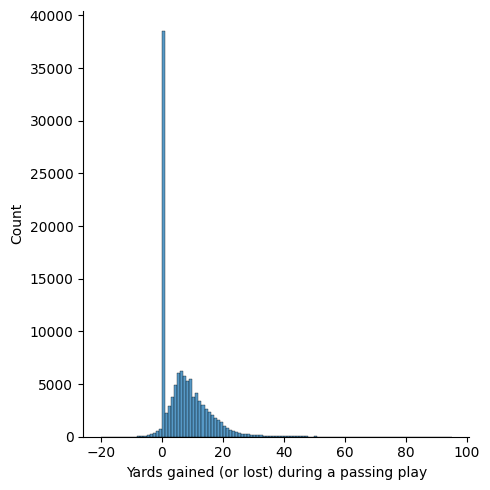

In [4]:
pbp_py_p_short = \
    pbp_py_p\
    .query('pass_length == "short"')

pbp_py_hist_short = \
    sns.displot(data=pbp_py_p_short,
                binwidth=1,
                x="passing_yards");
pbp_py_hist_short\
    .set_axis_labels("Yards gained (or lost) during a passing play on short passes", "Count");
plt.show();

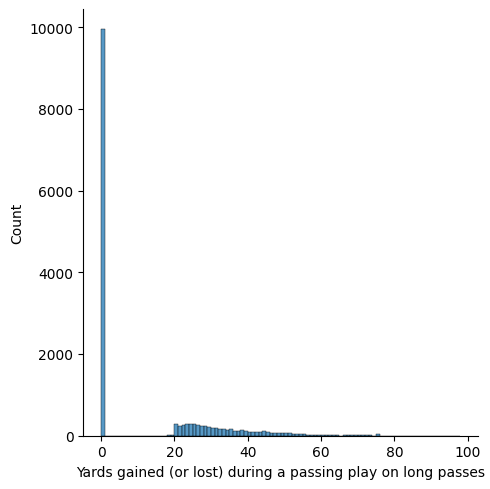

In [5]:
pbp_py_p_long = \
    pbp_py_p\
    .query('pass_length == "long"')

pbp_py_hist_long = \
    sns.displot(data=pbp_py_p_long,
                binwidth=1,
                x="passing_yards");
pbp_py_hist_long\
    .set_axis_labels("Yards gained (or lost) during a passing play on long passes", "Count");
plt.show();

#### Boxplot of yards gained from long and short air-yard passes (seaborn)

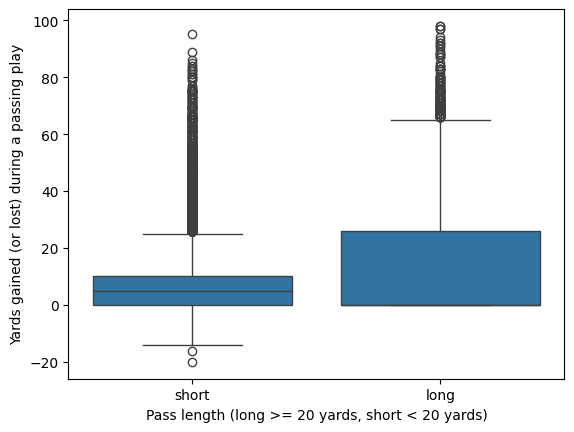

In [6]:
pass_boxplot = \
    sns.boxplot(data=pbp_py_p,
                x="pass_length",
                y="passing_yards");
pass_boxplot.set(     xlabel="Pass length (long >= 20 yards, short < 20 yards)",
    ylabel="Yards gained (or lost) during a passing play",
);
plt.show();

#### Quarterback Performance Analysis

In [9]:
pbp_py_p_s = \
    pbp_py_p\
    .groupby(["passer_id", "passer", "season"])\
    .agg({"passing_yards": ["mean", "count"]})
pbp_py_p_s.columns = list(map("_".join, pbp_py_p_s.columns.values))
pbp_py_p_s \
    .rename(columns={'passing_yards_mean': 'ypa',
                     'passing_yards_count': 'n'},
            inplace=True)
print(pbp_py_p_s\
    .sort_values(by=["ypa"], ascending=False)\
    .head())

                              ypa  n
passer_id  passer    season         
00-0035544 T.Kennedy 2021    75.0  1
00-0033132 K.Byard   2018    66.0  1
00-0031235 O.Beckham 2018    53.0  2
00-0030669 A.Wilson  2018    52.0  1
00-0029632 M.Sanu    2017    51.0  1


In [10]:
pbp_py_p_s_100 = \
    pbp_py_p_s\
    .query("n >= 100")\
    .sort_values(by=["ypa"], ascending=False)
print(pbp_py_p_s_100.head())

                                      ypa    n
passer_id  passer        season               
00-0023682 R.Fitzpatrick 2018    9.617887  246
00-0026143 M.Ryan        2016    9.442155  631
00-0029701 R.Tannehill   2019    9.069971  343
00-0033537 D.Watson      2020    8.898524  542
00-0036212 T.Tagovailoa  2022    8.892231  399


#### Year-over-Year Stability of QB Performance

In [12]:
pbp_py_p_s_pl = pbp_py_p\
    .groupby(["passer_id", "passer", "season", "pass_length"])\
    .agg({"passing_yards": ["mean", "count"]})
pbp_py_p_s_pl.columns = list(map("_".join, pbp_py_p_s_pl.columns.values)) 
pbp_py_p_s_pl.rename(columns={'passing_yards_mean': 'ypa',
                              'passing_yards_count': 'n'},
                     inplace=True)
pbp_py_p_s_pl.reset_index(inplace=True)
q_value = ('(n >= 100 & ' + 'pass_length == "short") | ' + '(n >= 30 & ' + 'pass_length == "long")'
)
pbp_py_p_s_pl = pbp_py_p_s_pl.query(q_value).reset_index()
cols_save = ["passer_id", "passer", "season", "pass_length", "ypa"]
air_yards_py = pbp_py_p_s_pl[cols_save].copy()
air_yards_lag_py = air_yards_py.copy()
air_yards_lag_py["season"] += 1
air_yards_lag_py.rename(columns={'ypa': 'ypa_last'}, inplace=True)
pbp_py_p_s_pl = air_yards_py.merge(air_yards_lag_py,
                                   how='inner',
                                   on=['passer_id', 'passer',
                                       'season', 'pass_length'])
print(pbp_py_p_s_pl[["pass_length", "passer",
                     "season", "ypa", "ypa_last"]]\
     .query('passer == "T.Brady" | passer == "A.Rodgers"')\
     .sort_values(["passer", "pass_length", "season"])\
     .to_string())

   pass_length     passer  season        ypa   ypa_last
47        long  A.Rodgers    2019  12.092592  12.011628
49        long  A.Rodgers    2020  16.097826  12.092592
51        long  A.Rodgers    2021  14.302631  16.097826
53        long  A.Rodgers    2022  10.312500  14.302631
45       short  A.Rodgers    2017   6.041475   6.693523
46       short  A.Rodgers    2018   6.697446   6.041475
48       short  A.Rodgers    2019   6.207224   6.697446
50       short  A.Rodgers    2020   6.718447   6.207224
52       short  A.Rodgers    2021   6.777083   6.718447
54       short  A.Rodgers    2022   6.239130   6.777083
0         long    T.Brady    2017  13.264706  15.768116
2         long    T.Brady    2018  10.232877  13.264706
4         long    T.Brady    2019  10.828571  10.232877
6         long    T.Brady    2020  12.252101  10.828571
8         long    T.Brady    2021  12.242424  12.252101
10        long    T.Brady    2022  10.802469  12.242424
1        short    T.Brady    2017   7.071429   7

In [13]:
pbp_py_p_s_pl\
    .info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 315 entries, 0 to 314
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   passer_id    315 non-null    object 
 1   passer       315 non-null    object 
 2   season       315 non-null    int64  
 3   pass_length  315 non-null    object 
 4   ypa          315 non-null    float32
 5   ypa_last     315 non-null    float32
dtypes: float32(2), int64(1), object(3)
memory usage: 14.8+ KB


In [15]:
len(pbp_py_p_s_pl.passer_id.unique())

65

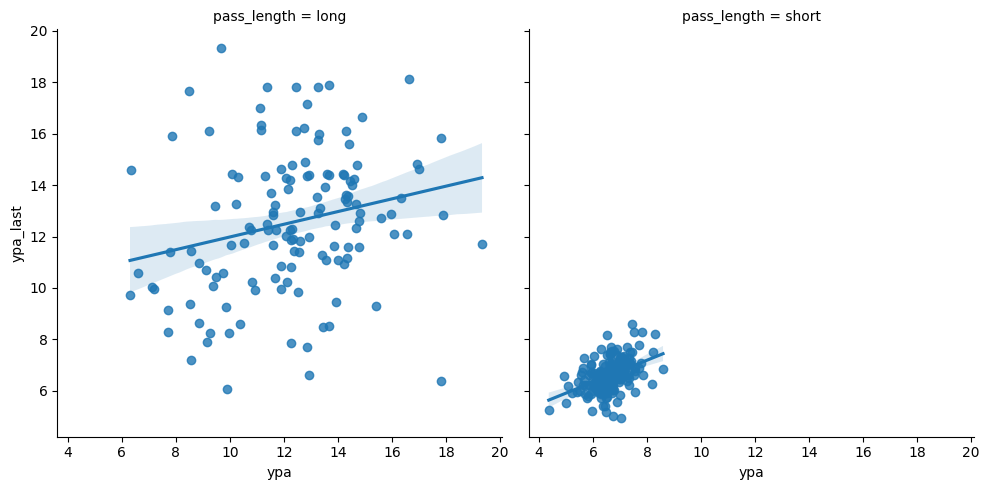

In [17]:
sns.lmplot(data=pbp_py_p_s_pl,
           x="ypa",
           y="ypa_last",
           col="pass_length");
plt.show();

In [20]:
print(pbp_py_p_s_pl\
    .query("ypa.notnull() & ypa_last.notnull()")\
    .groupby("pass_length")[["ypa", "ypa_last"]]\
    .corr())

                           ypa  ypa_last
pass_length                             
long        ypa       1.000000  0.232828
            ypa_last  0.232828  1.000000
short       ypa       1.000000  0.440016
            ypa_last  0.440016  1.000000


In [22]:
print(pbp_py_p_s_pl\
    .query('pass_length == "long" & season == 2017'
        )[["passer_id", "passer", "ypa"]]\
    .sort_values(["ypa"], ascending=False)\
    .head(10))

      passer_id      passer        ypa
41   00-0023436     A.Smith  19.338236
79   00-0026498  M.Stafford  17.830769
12   00-0020531     D.Brees  16.632353
191  00-0032950     C.Wentz  13.555555
33   00-0022942    P.Rivers  13.347826
0    00-0019596     T.Brady  13.264706
129  00-0029604   K.Cousins  12.847458
114  00-0029263    R.Wilson  12.738636
203  00-0033077  D.Prescott  12.585366
109  00-0028986    C.Keenum  11.904762


In [25]:
print(pbp_py_p_s_pl\
    .query('pass_length == "long" & season == 2018'
        )[["passer_id", "passer", "ypa"]]\
    .sort_values(["ypa"], ascending=False)\
    .head(10))

      passer_id      passer        ypa
116  00-0029263    R.Wilson  15.597403
14   00-0020531     D.Brees  14.903226
205  00-0033077  D.Prescott  14.771930
214  00-0033106      J.Goff  14.445946
35   00-0022942    P.Rivers  14.357142
157  00-0031280      D.Carr  14.339286
188  00-0032268   M.Mariota  13.941176
64   00-0026143      M.Ryan  13.465754
193  00-0032950     C.Wentz  13.222222
24   00-0022803   E.Manning  12.941176
